This is the copy of Flow Matching notebook. It is to see how smaller model will behave.

In [1]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math
from tqdm.notebook import tqdm

from src.model. models import DBModel
from src.data.helpers import get_moons_dataset, rotate, get_accuracy
from src.visualization.visualize import plot_decision_boundary

In [2]:
import pandas as pd

class ModelParamsDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, angle_change: int = 45):
        self.dataset_path = dataset_path
        self.dataset = pd.read_csv(dataset_path)
        self.dataset = self.dataset[self.dataset["angle"] % 90 == 0]
        self.angle_change = angle_change
        self.weights = self.dataset.drop(columns=["model_name", "angle"]).astype('float32')
        self.angles = self.dataset["angle"]
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        weights = torch.tensor(self.weights.iloc[idx].values)
        angle = torch.tensor(self.angles.iloc[idx], dtype=torch.int64)

        return weights, angle

In [3]:
class Flow(nn.Module):
    def __init__(self, hidden_dim=128):
        super(Flow, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(36, hidden_dim),
            nn.SELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SELU(),
            nn.Linear(hidden_dim, 33)
        )
    
    def forward(self, x):
        return self.layers(x)

In [4]:
def compute_conditional_vector_field(x0, x1):
    return x1 - x0


def sample_conditional_pt(x0, x1, t, sigma):
    t = t.reshape(-1, *([1] * (x0.dim() - 1)))
    mu_t = t * x1 + (1 - t) * x0
    epsilon = torch.randn_like(x0)
    return mu_t + sigma * epsilon

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Hyperparameters
epochs = 1000
lr = 1e-3
batch_size = 100
hidden_dim = 512

torch.manual_seed(0)

# Dataset
dataset = ModelParamsDataset("../../data/zoo_small.csv")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model
flow = Flow(hidden_dim)
flow.to(device)
optimizer = torch.optim.Adam(flow.parameters(), lr=lr)

# Gaussian prior
prior_dim = 33
prior_sd = 1
gaussian = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(prior_dim), math.sqrt(prior_sd) * torch.eye(prior_dim))

path = "../../models/generators/flow_matching_half_angles/"
model_path = path + "flow_small_conditional.pth"


In [12]:
losses = []
accuracies_per_epoch = []
angles = [0, 45, 90, 135, 180, 225, 270, 315, 45/2, 135/2, 225/2, 315/2, 405/2, 495/2, 585/2, 675/2]

for epoch in tqdm(range(epochs)):    
    for X, y in dataloader:
        optimizer.zero_grad()
        x0 = gaussian.sample((batch_size,)).to(device)
        x1 = X.to(device)

        t = torch.rand(x0.shape[0]).type_as(x0).to(device)

        y = y * torch.pi / 180
        sin = torch.sin(y).to(device)
        cos = torch.cos(y).to(device)

        xt = sample_conditional_pt(x0, x1, t, sigma=0.01)
        ut = compute_conditional_vector_field(x0, x1)        

        vt = flow(torch.cat([xt, t[:, None], sin[:, None], cos[:, None]], dim=-1))
        loss = torch.mean((vt - ut) ** 2)

        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}")
        losses.append(loss.item())

    if epoch % 200 == 0:
        flow.to("cpu")
        accuracies = []
        with torch.no_grad():
            for angle in angles:
                for i in range(10):
                    x = generate(flow, angle)[0]
                    x = torch.tensor(x, dtype=torch.float32)

                    X, y = get_moons_dataset()
                    X_rotated = rotate(X, angle)
                    X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

                    accuracy = get_accuracy(x, X_rotated, y)
                    accuracies.append(accuracy)
            
            accuracies_per_epoch.append(np.mean(accuracies))
            torch.save(flow.state_dict(), f"{path}flow_matching_{epoch}.pth")
        flow.to(device)

torch.save(flow.state_dict(), model_path)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0: Loss 3.4846608638763428


C:\Users\JetFire\AppData\Local\Temp\ipykernel_17152\4236868358.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Epoch 10: Loss 2.8297531604766846
Epoch 20: Loss 3.2555811405181885
Epoch 30: Loss 2.653268575668335
Epoch 40: Loss 2.9961514472961426
Epoch 50: Loss 2.6458687782287598
Epoch 60: Loss 2.809141159057617
Epoch 70: Loss 2.8279948234558105
Epoch 80: Loss 2.8328332901000977
Epoch 90: Loss 2.6999011039733887
Epoch 100: Loss 2.54502010345459
Epoch 110: Loss 2.679574489593506
Epoch 120: Loss 2.7485742568969727
Epoch 130: Loss 2.696725845336914
Epoch 140: Loss 2.782379627227783
Epoch 150: Loss 2.549492835998535
Epoch 160: Loss 2.7114317417144775
Epoch 170: Loss 2.882385492324829
Epoch 180: Loss 2.55098032951355
Epoch 190: Loss 2.7592780590057373
Epoch 200: Loss 2.600487232208252
Epoch 210: Loss 2.8793416023254395
Epoch 220: Loss 2.644780397415161
Epoch 230: Loss 2.5521857738494873
Epoch 240: Loss 2.4598300457000732
Epoch 250: Loss 2.526052951812744
Epoch 260: Loss 2.7231826782226562
Epoch 270: Loss 2.681561231613159
Epoch 280: Loss 2.5123212337493896
Epoch 290: Loss 2.6023919582366943
Epoch 300

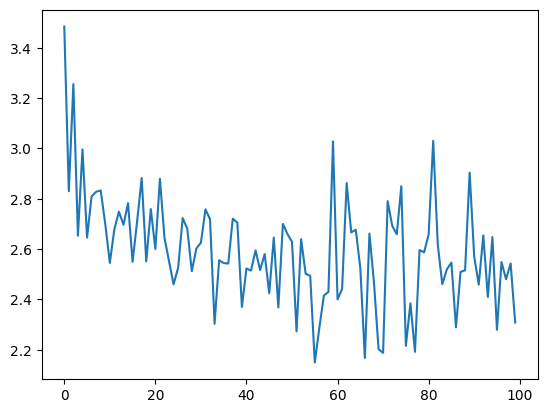

In [13]:
plt.plot(losses)

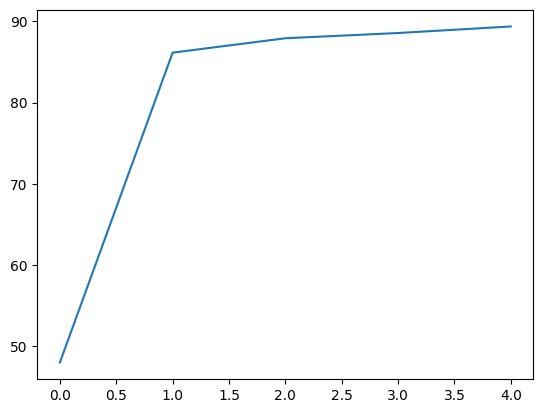

In [14]:
plt.plot(accuracies_per_epoch)


## Conditional Generation

In [6]:
def generate(model, angle, num_iter=100):
    x = gaussian.sample((1,))
    angle = torch.tensor([angle*torch.pi/180])
    for i in np.linspace(0, 1, num_iter, endpoint=False):
        t = torch.tensor([i], dtype=torch.float32)
        sin = torch.sin(angle)
        cos = torch.cos(angle)
        path = model(torch.cat([x, t[:, None], sin[:, None], cos[:, None]], dim=-1))
        x += (1/num_iter * path)
    return x.detach()

In [ ]:
flow = Flow(hidden_dim)
flow.load_state_dict(torch.load(model_path))
flow.eval()

def slider(angle):
    x = generate(flow, angle, num_iter=100)[0]
    X, y = get_moons_dataset()
    X_rotated = rotate(X, angle)
    plot_decision_boundary(x, X_rotated, y, title=f"{angle}° degrees")

from ipywidgets import interact
interact(slider, angle=(0, 360, 1))

interactive(children=(IntSlider(value=180, description='angle', max=360), Output()), _dom_classes=('widget-int…

<function __main__.slider(angle)>

  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\JetFire\AppData\Local\Temp\ipykernel_14632\2290989138.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Mean accuracy: 93.37125


<Axes: ylabel='Density'>

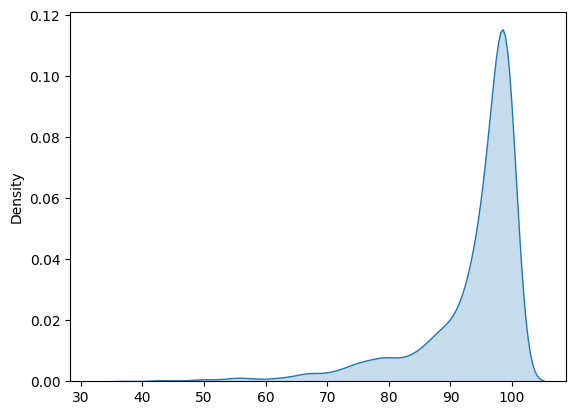

In [8]:
flow = Flow(hidden_dim)
flow.load_state_dict(torch.load(model_path))
flow.eval()

accuracies = []
angles = [0, 90, 180, 270]

with torch.no_grad():
    for angle in tqdm(angles):
        for i in range(1000):
            x = generate(flow, angle)[0]
            x = torch.tensor(x, dtype=torch.float32)

            X, y = get_moons_dataset()
            X_rotated = rotate(X, angle)
            X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

            accuracy = get_accuracy(x, X_rotated, y)
            accuracies.append(accuracy)
    

print("Mean accuracy:", np.mean(accuracies))
sns.kdeplot(accuracies, fill=True)

  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\JetFire\AppData\Local\Temp\ipykernel_14632\665767262.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Mean accuracy: 85.36222500000001


<Axes: ylabel='Density'>

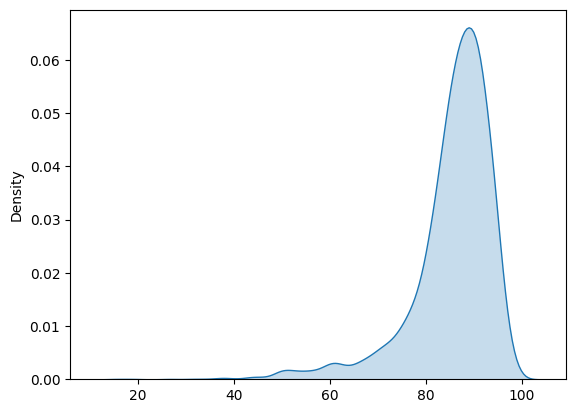

In [10]:
flow = Flow(hidden_dim)
flow.load_state_dict(torch.load(model_path))
flow.eval()

accuracies = []
angles = [45, 135, 225, 315]

with torch.no_grad():
    for angle in tqdm(angles):
        for i in range(1000):
            x = generate(flow, angle)[0]
            x = torch.tensor(x, dtype=torch.float32)

            X, y = get_moons_dataset()
            X_rotated = rotate(X, angle)
            X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

            accuracy = get_accuracy(x, X_rotated, y)
            accuracies.append(accuracy)
    

print("Mean accuracy:", np.mean(accuracies))
sns.kdeplot(accuracies, fill=True)

## Parameters distribution

In [29]:
flow = Flow(1024)
flow.load_state_dict(torch.load(model_path))
flow.eval()

angle = 0
accuracies = []

X, y = get_moons_dataset()
X = torch.tensor(X, dtype=torch.float32)

for i in range(1000):
    parameters = generate(flow, angle, num_iter=100)[0]
    accuracy = get_accuracy(parameters, X, y)
    accuracies.append(accuracy)
    
print("Mean accuracy:", np.mean(accuracies))

Mean accuracy: 93.38789999999999


(33, 1000)


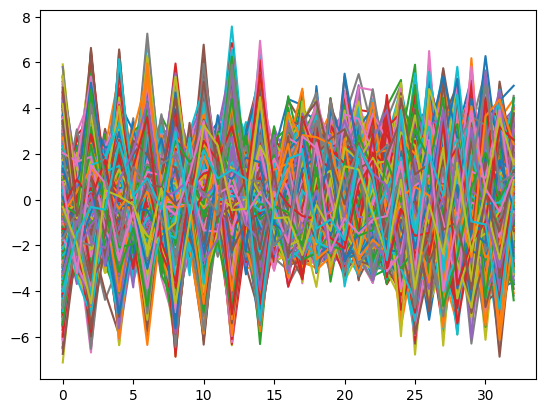

In [19]:
parameters = np.array(parameters)
print(parameters.T.shape)

plt.plot(parameters.T)
plt.show()